### Imports

In [1]:
import os
import random
import functools
import cv2
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [2]:
import imagehash
import torch

In [47]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
from chestxray.visualize import show_from_ids
# Competition related config
from chestxray.config import CFG

#### Global Constants

### Retrieve the Images

In [4]:
ls -la {PANDA_PATH}/

total 3176
drwxrwxr-x 6 ademyanchuk ademyanchuk   4096 Jun  6 10:19 ./
drwxr-xr-x 8 ademyanchuk ademyanchuk   4096 Apr 28 13:53 ../
-rw-rw-r-- 1 ademyanchuk ademyanchuk 517985 Jun  4 18:00 folds_cleaned.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk 541440 May  4 22:31 folds.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk   5140 May  6 19:15 folds_db.csv
drwxrwxr-x 2 ademyanchuk ademyanchuk   4096 May 28 08:16 hdf5/
drwxrwxr-x 3 ademyanchuk ademyanchuk   4096 Jun  6 10:56 jpeg/
-r--r--r-- 1 ademyanchuk ademyanchuk  29380 Jun  3 17:15 PANDA_Suspicious_Slides.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk    125 Apr 22 02:10 sample_submission.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk    149 Apr 22 02:10 test.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk 520203 Apr 22 02:10 train.csv
drwxrwxr-x 2 ademyanchuk ademyanchuk 790528 May 23 10:56 train_images/
drwxrwxr-x 2 ademyanchuk ademyanchuk 802816 Apr 28 23:33 train_label_masks/


In [5]:
PANDA_IMGS

PosixPath('/home/ademyanchuk/Projects/ChestXRay/data/Panda/train_images')

In [6]:
JPEG_IMGS = PANDA_PATH/"jpeg/train_images"

In [7]:
FOLDS = pd.read_csv(PANDA_PATH/"folds_cleaned.csv")

In [8]:
FOLDS.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,3
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,3


In [9]:
FOLDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10140 entries, 0 to 10139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10140 non-null  object
 1   data_provider  10140 non-null  object
 2   isup_grade     10140 non-null  int64 
 3   gleason_score  10140 non-null  object
 4   fold           10140 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 396.2+ KB


In [10]:
# Try on small sample first
# FOLDS = FOLDS.sample(500)

### Make Hashes

In [11]:
def img_path_from_id(folder, image_id, as_string=False, suffix=".tiff"):
    path = folder / (image_id + suffix)
    if as_string:
        return str(path)
    return path

In [12]:
funcs = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash,
]

In [13]:
paths = [img_path_from_id(JPEG_IMGS, img_id, as_string=True, suffix="_1.jpeg") for img_id in FOLDS.image_id]

In [14]:
print(f"{len(paths)} prepared")

10140 prepared


In [15]:
hashes = []
for path in tqdm(paths, total=len(paths)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

100%|██████████| 10140/10140 [4:26:52<00:00,  1.58s/it]  


In [16]:
hashes = np.array(hashes).astype(int)
with open(PANDA_PATH/"hashes.npy", "wb") as f:
    np.save(f, hashes)

In [17]:
hashes.shape

(10140, 256)

In [18]:
hashes = torch.Tensor(np.array(hashes).astype(int)).cuda()

In [19]:
hashes.shape

torch.Size([10140, 256])

In [20]:
# calc similarity scores
sims = np.array([(hashes[i] == hashes).sum(dim=1).cpu().numpy()/256 for i in range(hashes.shape[0])])

In [178]:
# lower threshold gave false positives
threshold = 0.96

In [179]:
groups = defaultdict(lambda: list())
visited = set()
for i in range(len(sims)):
    if i in visited:
        continue
    visited.add(i)
    for j in range(i+1, len(sims[i])):
        if j in visited:
            continue
        if sims[i,j] > threshold:
            groups[i].append(j)
            visited.add(j)

In [180]:
len(visited)

10140

In [181]:
len(groups)

78

IndexError: list index out of range

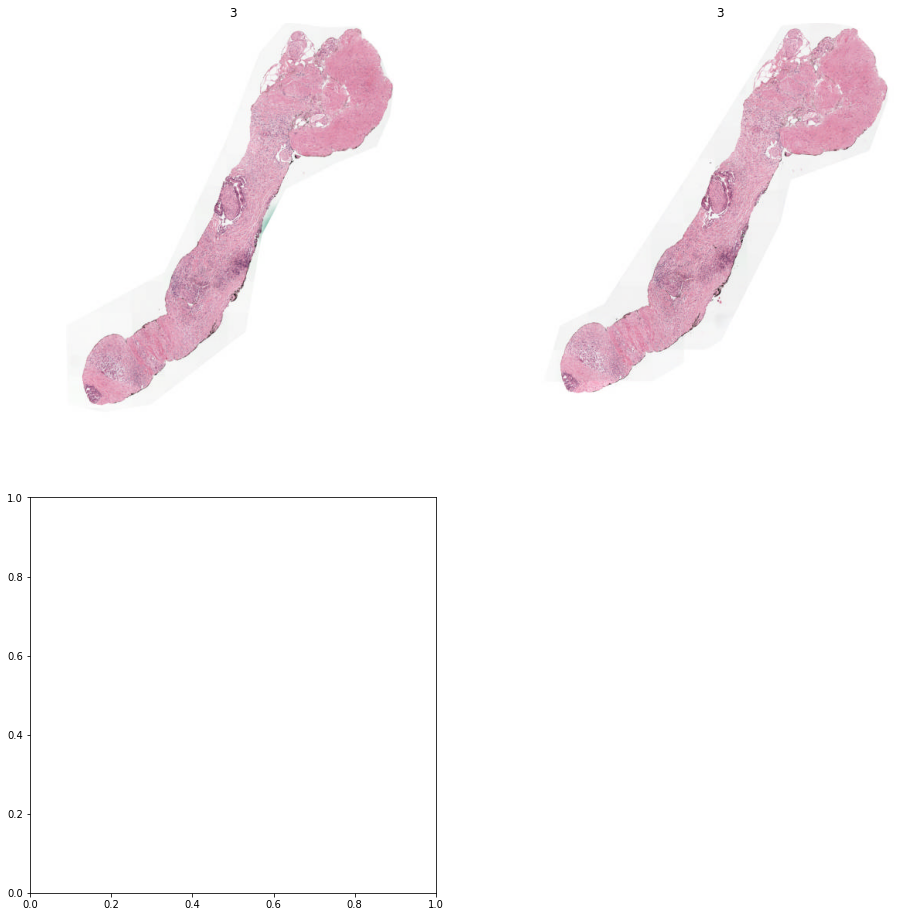

In [225]:
key = random.choice(list(groups.keys()))
ids = FOLDS.loc[[key] + groups[key], "image_id"].values
show_from_ids(ids, FOLDS)

In [190]:
dupl_ids = []
for key in groups:
    dupl_ids.append(key)
    dupl_ids.extend(groups[key])

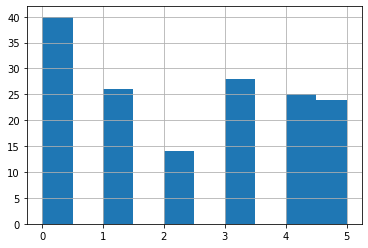

In [193]:
FOLDS.loc[dupl_ids, "isup_grade"].hist()

In [213]:
len(dupl_ids)

157

In [226]:
# I decided just drop duplicates from dataframe
drop_ids = []
for key in groups:
    drop_ids.extend(groups[key])

In [231]:
FOLDS.drop(index=drop_ids)

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,3
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,3
...,...,...,...,...,...
10135,ffcee00fd033d3ece1408035a7fd4ea7,karolinska,1,3+3,0
10136,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,3
10137,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5,1
10138,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,1


In [230]:
FOLDS.drop(index=drop_ids).to_csv(PANDA_PATH/"folds_dedup.csv", index=False, header=True)